### Geometric Optimization of Dose Distribution in Spatially Fractionated Radiation Therapy

Copyright (c) 2024 Seyedmohammadhossein Hosseinian. All rights reserved.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import numpy as np
import math

In [2]:
tumor = pd.read_csv('CH_GTV_GRID.csv')
x_min = tumor['X'].min()
x_max = tumor['X'].max()
y_min = tumor['Y'].min()
y_max = tumor['Y'].max()
z_min = tumor['Z'].min()
z_max = tumor['Z'].max()

In [3]:
ellipsoids_0 = [[0.25,0.25,0.25],[0.53,0.55,0.3],[0.65,0.66,0.54],[0.77,0.78,0.65],[0.88,0.9,0.76],[1,1.04,0.87],[1.26,1.29,0.97],[1.55,1.6,1.11],[2.15,2.32,1.25],[3.42,4.59,1.4],[10,10,10]]
ellipsoids_1 = [[0.5,0.5,0.5],[0.61,0.62,0.58],[0.72,0.72,0.66],[0.83,0.82,0.74],[0.93,0.93,0.82],[1.09,1.06,0.9],[1.33,1.3,0.98],[1.65,1.6,1.12],[2.26,2.3,1.26],[3.62,4.51,1.41],[10,10,10]]
ellipsoids_2 = [[1.0,1.0,1.0],[1.13,1.15,1.08],[1.25,1.28,1.16],[1.37,1.41,1.24],[1.49,1.58,1.32],[1.76,1.85,1.39],[2.05,2.22,1.47],[2.63,2.86,1.6],[3.73,4.27,1.76],[5.75,8.82,1.91],[10,10,10]]
ellipsoids = [ellipsoids_0, ellipsoids_1, ellipsoids_2]
doses = [50,45,40,35,30,25,20,15,10,5,0]
spheres = [[-0.6, -1.03, -51.21, 0], [-3.6, 4.67, -51.21, 1], [-1.5, 2.27, -48.21, 2]]

In [4]:
x_line = np.linspace(x_min, x_max, 200) 
y_line = np.linspace(y_min, y_max, 200)
x_mesh, y_mesh = np.meshgrid(x_line, y_line)
x_mesh_center = []
y_mesh_center = []
for i in range(len(x_line) - 1):
    x_mesh_center.append(0.5*(x_line[i] + x_line[i+1]))
for j in range(len(y_line) - 1):
    y_mesh_center.append(0.5*(y_line[j] + y_line[j+1]))

In [5]:
def is_inside_ellipsoid(point, center, a, b, c):
    x, y, z = point
    dx, dy, dz = center
    return ((x - dx)**2 / a**2 + (y - dy)**2 / b**2 + (z - dz)**2 / c**2) <= 1
#
def find_intersection(ellipsoid, center, point_e):
    a, b, c = ellipsoid
    d_x, d_y, d_z = center
    e_x, e_y, e_z = point_e
    dir_x = e_x - d_x
    dir_y = e_y - d_y
    dir_z = e_z - d_z
    A = (dir_x / a) ** 2 + (dir_y / b) ** 2 + (dir_z / c) ** 2
    B = 0
    C = -1
    t_values = np.roots([A, B, C])
    intersection_points = [(d_x + t * dir_x, d_y + t * dir_y, d_z + t * dir_z) for t in t_values if np.isreal(t)]
    temp = 1000
    final_point = intersection_points[0]
    for p in intersection_points:
        dist = math.sqrt((p[0] - e_x) ** 2 + (p[1] - e_y) ** 2 + (p[2] - e_z) ** 2)
        if dist < temp:
            temp = dist
            final_point = p
    return final_point
#
def interpolate_dose(point, center, ellipsoids, doses):
    inside = [is_inside_ellipsoid(point, center, ellipsoid[0], ellipsoid[1], ellipsoid[2]) for ellipsoid in ellipsoids]
    for i in range(len(inside) - 1):
        if inside[i] != inside[i + 1]:
            dose_diff = doses[i] - doses[i + 1]
            ellipsoid_outer = (ellipsoids[i+1][0], ellipsoids[i+1][1], ellipsoids[i+1][2])
            ellipsoid_inner = (ellipsoids[i][0], ellipsoids[i][1], ellipsoids[i][2])
            point_outer = find_intersection(ellipsoid_outer, center, point)
            point_inner = find_intersection(ellipsoid_inner, center, point)
            dist_outer = math.sqrt((point[0] - point_outer[0]) ** 2 + (point[1] - point_outer[1]) ** 2 + (point[2] - point_outer[2]) ** 2)
            dist_inner = math.sqrt((point[0] - point_inner[0]) ** 2 + (point[1] - point_inner[1]) ** 2 + (point[2] - point_inner[2]) ** 2)
            return doses[i + 1] + dose_diff * (dist_outer) / (dist_outer + dist_inner) 
    return doses[0] if inside[0] else doses[-1]
#
def calculate_dose(point, spheres, ellipsoids, doses):
    dose = 0
    for s in spheres:
        dose = dose + interpolate_dose(point, [s[0],s[1],s[2]], ellipsoids[s[3]], doses)
    return dose

In [6]:
unique_z_values = tumor['Z'].unique()
unique_z_values.sort()
ALL = []
for z in unique_z_values:
    fixed_z = tumor[tumor['Z'] == z]
    temp = fixed_z.values.tolist()
    ALL.append(temp)

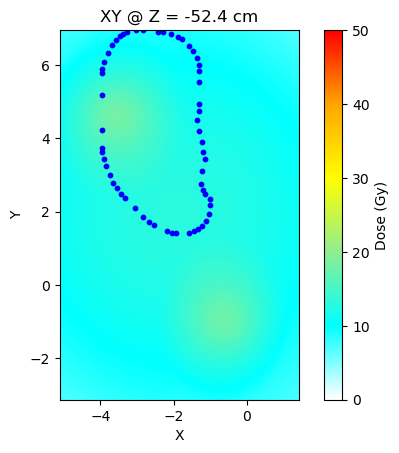

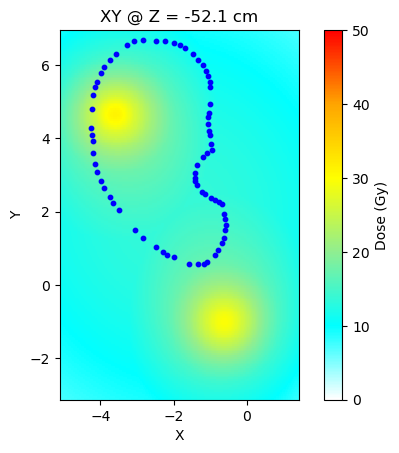

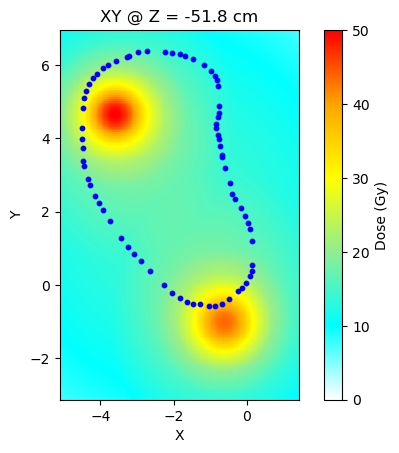

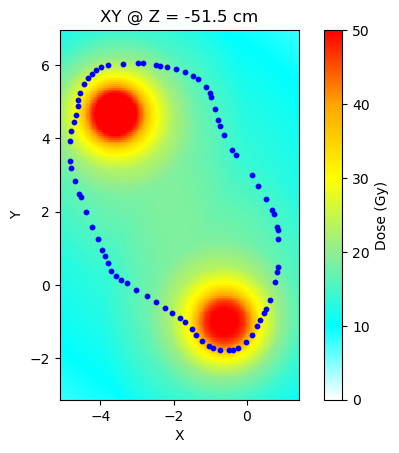

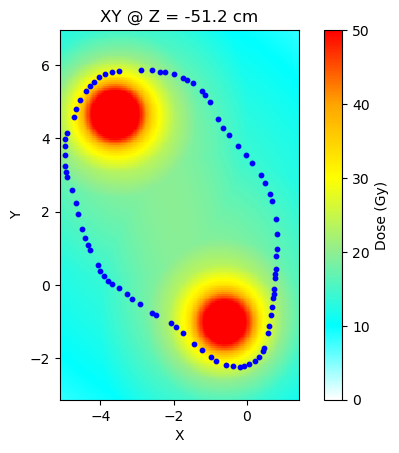

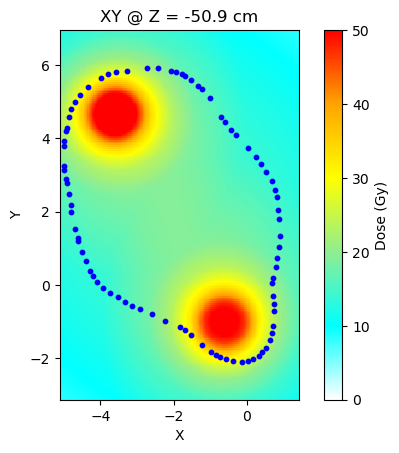

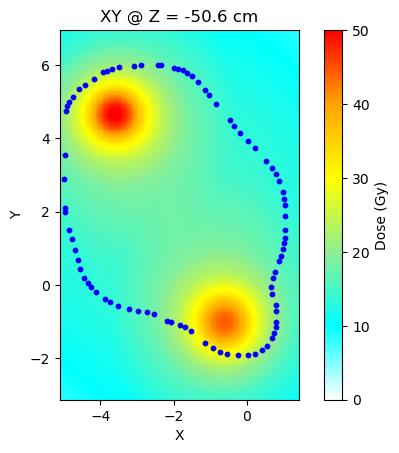

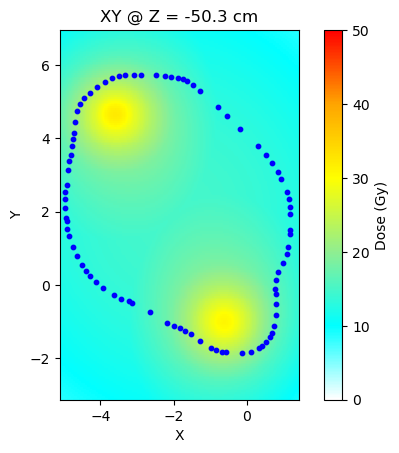

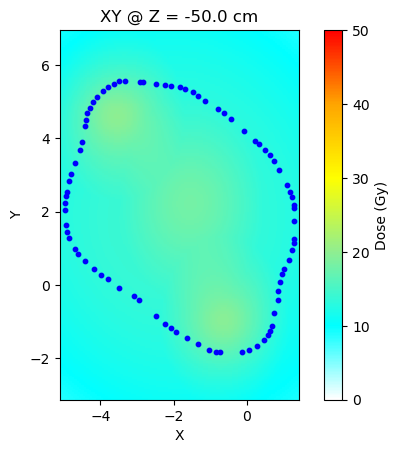

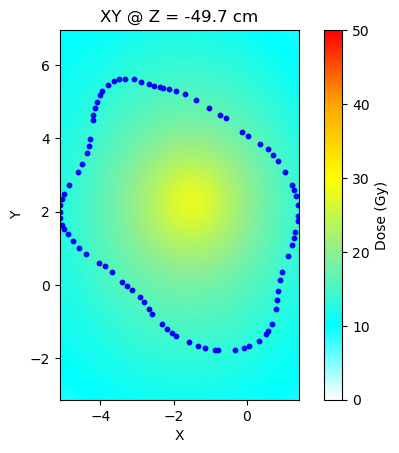

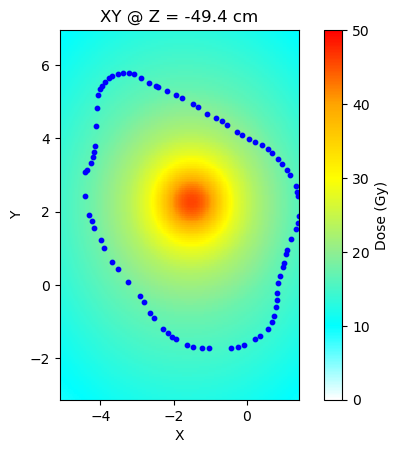

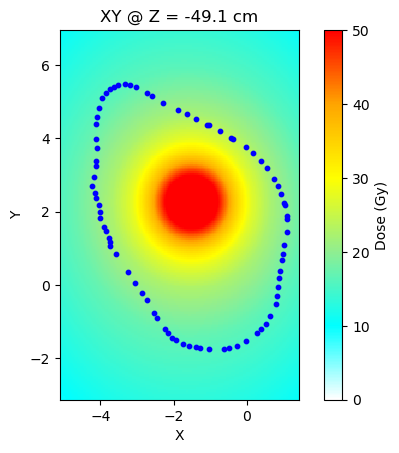

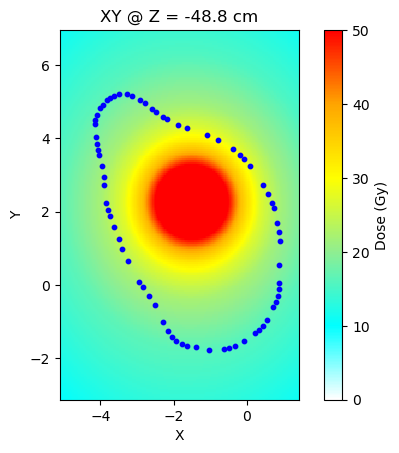

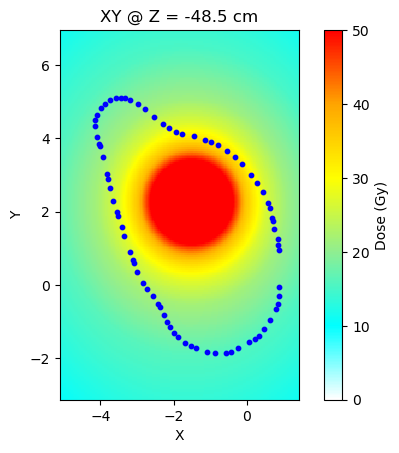

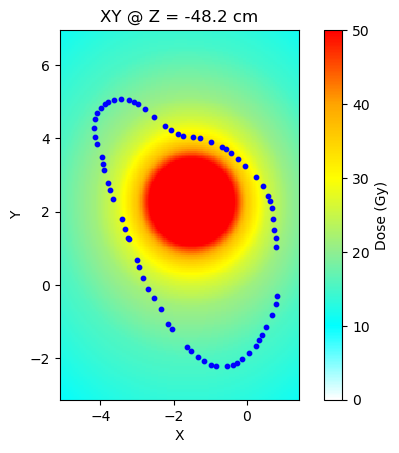

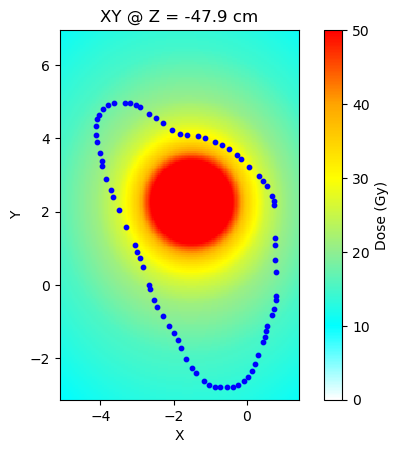

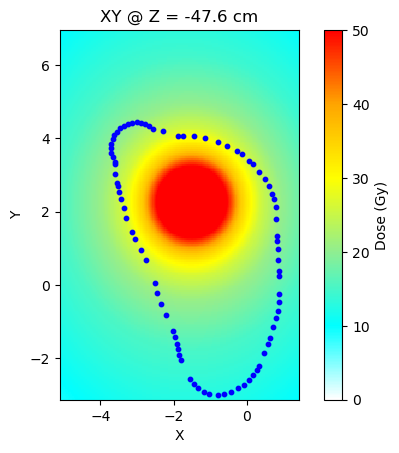

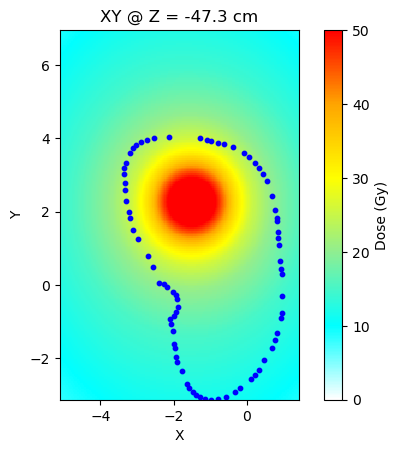

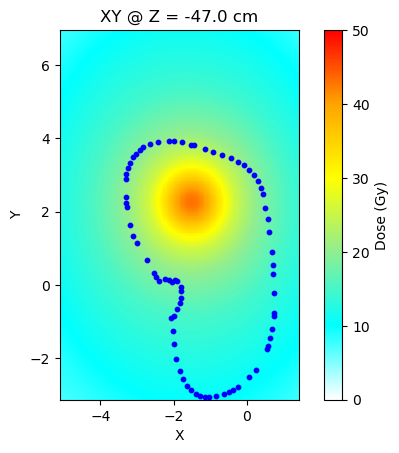

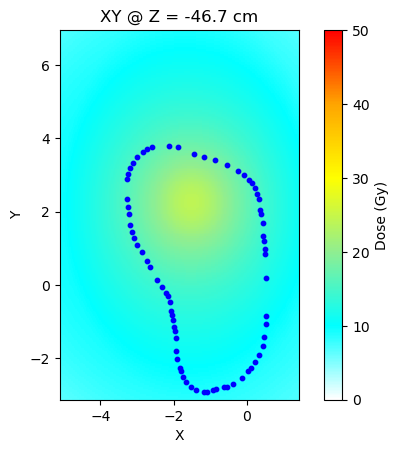

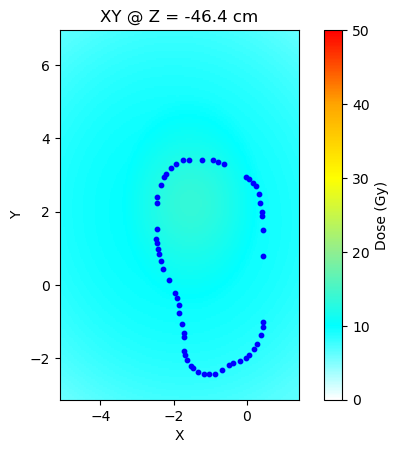

In [7]:
for z_ind in range(len(unique_z_values)):
    z = unique_z_values[z_ind]
    values = np.zeros((len(x_mesh_center),len(y_mesh_center)))
    for i in range(len(values)):
        for j in range(len(values[i])):
            values[j][i] = calculate_dose([x_mesh_center[i],y_mesh_center[j],z], spheres, ellipsoids, doses)
    cmap = LinearSegmentedColormap.from_list("WClGYOR", ["white", "cyan" , "lightgreen", "yellow", "orange", "red"])
    x_tumor_z = []
    y_tumor_z = []
    for e in ALL[z_ind]:
        x_tumor_z.append(e[0])
        y_tumor_z.append(e[1])
    #plt.figure()
    fig, ax = plt.subplots()
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.pcolormesh(x_mesh, y_mesh, values, cmap=cmap, vmin=0, vmax=50, shading='auto')
    plt.colorbar(label='Dose (Gy)') 
    plt.scatter(x_tumor_z, y_tumor_z, c='blue', marker='o',s=10)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title((f'XY @ Z = {np.round(z,1)} cm'))
    ax.set_aspect('equal')
    plt.show()